In [1]:
import spherical_inr as sph
import torch 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cartopy.crs as ccrs


In [36]:
hnet = sph.HerglotzNet( 
    output_dim=1,
    inr_sizes = [5] + 3*[50],
    hidden_omega0=5.0
)

In [37]:
siren = sph.SirenNet(
    input_dim=2,
    output_dim=1, 
    inr_sizes= [5**2] + 3*[50],
    first_omega0=5.0
)

In [38]:
sph_siren = sph.SphericalSirenNet(
    output_dim =1,
    inr_sizes= [5] + 3*[50],
    hidden_omega0=5.0,
)

In [39]:
def target(theta, phi):
    return torch.sin(3*theta) * torch.cos(5*phi)

In [40]:
# Generate a grid of theta and phi values
theta = torch.linspace(0, torch.pi, 100)
phi = torch.linspace(0, 2 * torch.pi, 100)
theta, phi = torch.meshgrid(theta, phi, indexing='ij')

xtrain = torch.stack([theta, phi], dim=-1).reshape(-1, 2)
ytrain = target(theta, phi).reshape(-1, 1)

In [41]:
num_epochs = 1000
optimizer = torch.optim.Adam(hnet.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    ypred = hnet(xtrain)
    loss = torch.mean((ypred - ytrain)**2)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.5f}")

Epoch 0, Loss 0.39563
Epoch 100, Loss 0.06392
Epoch 200, Loss 0.00345
Epoch 300, Loss 0.00162
Epoch 400, Loss 0.00113
Epoch 500, Loss 0.00090
Epoch 600, Loss 0.00075
Epoch 700, Loss 0.00064
Epoch 800, Loss 0.00056
Epoch 900, Loss 0.00049


In [42]:
num_epochs = 1000
optimizer = torch.optim.Adam(siren.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    ypred = siren(xtrain)
    loss = torch.mean((ypred - ytrain)**2)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.5f}")

Epoch 0, Loss 1.49315
Epoch 100, Loss 0.02857
Epoch 200, Loss 0.00616
Epoch 300, Loss 0.00294
Epoch 400, Loss 0.00181
Epoch 500, Loss 0.00124
Epoch 600, Loss 0.00090
Epoch 700, Loss 0.00068
Epoch 800, Loss 0.00053
Epoch 900, Loss 0.00043


In [43]:
num_epochs = 1000
optimizer = torch.optim.Adam(sph_siren.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    ypred = sph_siren(xtrain)
    loss = torch.mean((ypred - ytrain)**2)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.5f}")

Epoch 0, Loss 0.26693
Epoch 100, Loss 0.00860
Epoch 200, Loss 0.00343
Epoch 300, Loss 0.00211
Epoch 400, Loss 0.00148
Epoch 500, Loss 0.00111
Epoch 600, Loss 0.00085
Epoch 700, Loss 0.00067
Epoch 800, Loss 0.00054
Epoch 900, Loss 0.00045


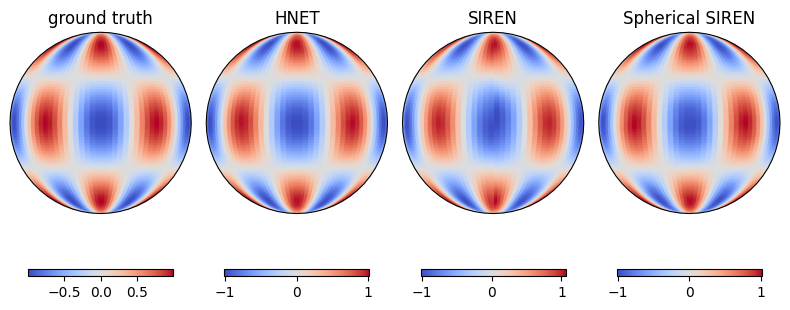

In [44]:
ypred_hnet_plot = hnet(xtrain).detach().numpy().reshape(100, 100)
ypred_siren_plot = siren(xtrain).detach().numpy().reshape(100, 100)
ypred_sh_siren_plot = sph_siren(xtrain).detach().numpy().reshape(100, 100)
ytrain_plot = ytrain.numpy().reshape(100, 100)


fig = plt.figure(figsize=(8, 4), dpi=100)

ax1 = fig.add_subplot(141, projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0))
im1 = ax1.imshow(ytrain_plot, extent=[0, 360, -90, 90], transform=ccrs.PlateCarree(), cmap="coolwarm")
ax1.set_title("ground truth")
fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=0.8)

ax2 = fig.add_subplot(142, projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0))
im2 = ax2.imshow(ypred_hnet_plot, extent=[0, 360, -90, 90], transform=ccrs.PlateCarree(), cmap="coolwarm")
ax2.set_title("HNET")
fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=0.8)

ax3 = fig.add_subplot(143, projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0))
im3 = ax3.imshow(ypred_siren_plot, extent=[0, 360, -90, 90], transform=ccrs.PlateCarree(), cmap="coolwarm")
ax3.set_title("SIREN")
fig.colorbar(im3, ax=ax3, orientation='horizontal', shrink=0.8)

ax4 = fig.add_subplot(144, projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0))
im4 = ax4.imshow(ypred_sh_siren_plot, extent=[0, 360, -90, 90], transform=ccrs.PlateCarree(), cmap="coolwarm")
ax4.set_title("Spherical SIREN")
fig.colorbar(im4, ax=ax4, orientation='horizontal', shrink=0.8)


plt.tight_layout()
plt.show()